<div align = 'center'> Project 1 - Linear Regression and Model Comparison (LBA) 
    
<div align = 'center'> Macbeth K. Matibe
    
<div align = 'center'> Minerva University
    
<div align = 'center'> CS146: Computational Methods for Bayesian Statistics
    
<div align = 'center'> Prof. Volkan
    
<div align = 'center'> October 21, 2023

## Executive Summary

executive summary  goes here

## The Dataset

data source --> https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set 


Real estate valuation data set. (2018). UCI Machine Learning Repository. https://doi.org/10.24432/C5J30W. 

## Loading the Data and importing necessary Libraries

In [1]:
# Import the necessary libraries
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as sts

# Several warnings print out about performance so adding this to remove them.
import pytensor


# Load the data from the CSV file
real_estate = pd.read_csv('Real estate.csv', encoding = "utf-8")
print('This is the Real Estate data')
real_estate = real_estate[real_estate['Y house price of unit area'] <= 100]
real_estate.head()

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


This is the Real Estate data


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


## Data Visualization (Scatter Plots of House Price of Unit Area vs Each Independent Variable)

In [ ]:
# List of columns to plot against 'house price'
except_col = {'Y house price of unit area', 'No'}
columns_to_plot = [col for col in real_estate.columns if col not in except_col]

for col in columns_to_plot:
    plt.figure(figsize = (8, 6))  
    plt.scatter(real_estate['Y house price of unit area'], real_estate[col], alpha = 0.5)
    plt.title(f'Scatter plot of {col} vs. House Unit Price')
    plt.ylabel(col)
    plt.xlabel('Y house price of unit area')
    plt.show()

## Model 1: 

Discuss Model 1 here

In [4]:
# Linear Model with Normal Likelihood:
with pm.Model() as linear_model:
    # Priors
    a = pm.Normal('a', mu = 0, sigma = 100)
    b = pm.Normal('b', mu = 0, sigma = 10)
    sigma = pm.Uniform('sigma', 0, 30)
    
    # Function
    mu = a + b* real_estate['X3 distance to the nearest MRT station']
    
    # Likelihood 
    unit_price = pm.Normal('unit_price', mu = mu, sigma = sigma, 
                           observed = real_estate['Y house price of unit area'])
    
    # Sampling
    linear_trace = pm.sample(tune = 1000, draws = 1000, chains = 2)
    
# results
az.summary(linear_trace, var_names = ['a', 'b', 'sigma'])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [a, b, sigma]
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 696 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,45.549,0.631,44.436,46.744,0.019,0.014,1076.0,945.0,1.0
b,-0.007,0.000,-0.008,-0.006,0.000,0.000,1088.0,1114.0,1.0
sigma,9.438,0.335,8.810,10.043,0.008,0.006,1639.0,1220.0,1.0


#### Checking the Sampler

interpret rank plots, trace plots and interpret the values of r_hat and ESS, basically the az summary table here

### Visualizing the Model fit (Normal Likelihood)

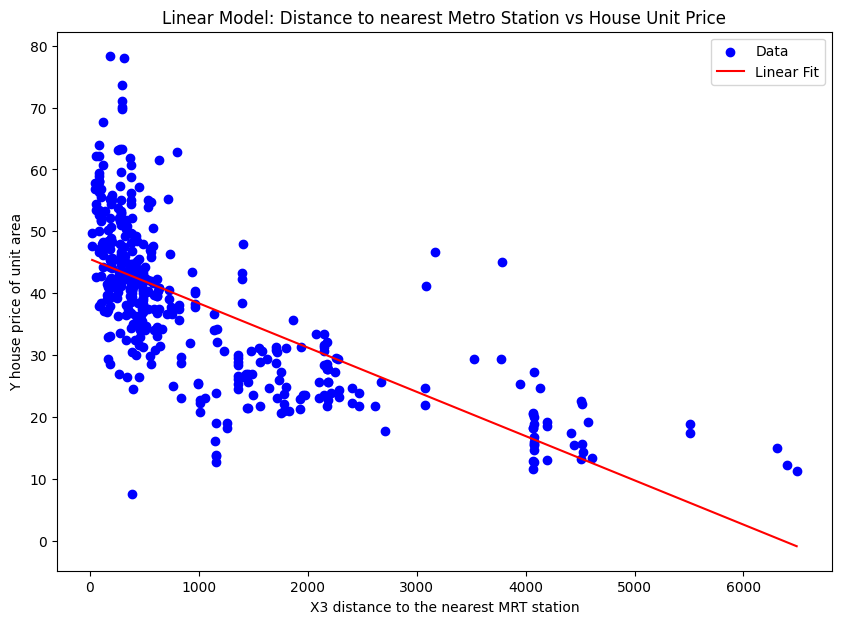

In [10]:
# Compute mean values for alpha and beta
a_samples = linear_trace.posterior["a"].values
b_samples = linear_trace.posterior["b"].values

a_mean = a_samples.mean()
b_mean = b_samples.mean()

# Generate predicted values using the mean parameter estimates
x_vals = np.linspace(min(real_estate['X3 distance to the nearest MRT station']), 
                     max(real_estate['X3 distance to the nearest MRT station']), 100)
y_vals_linear = a_mean + b_mean * x_vals

# Plot the data with line of best fit
plt.figure(figsize=(10, 8))
plt.scatter(real_estate['X3 distance to the nearest MRT station'], 
            real_estate['Y house price of unit area'], 
            c = 'blue', label = 'Data')
plt.plot(x_vals, y_vals_linear, c = 'red', label = 'Line of best Fit')
plt.title('Linear Model: Distance to nearest Metro Station vs House Unit Price')
plt.xlabel('X3 distance to the nearest MRT station')
plt.ylabel('Y house price of unit area')
plt.legend()
plt.show()

## Model 2: 

Discuss Model 2 here

In [13]:
# Robust Linear Model with Student T likelihood
with pm.Model() as robust_linear_model:
    # Priors
    a = pm.Normal('a', mu = 0, sigma = 100)
    b = pm.Normal('b', mu = 0, sigma = 10)
    nu = pm.Exponential('nu', 1/30) + 1  # degrees of freedom for Student's T
    sigma = pm.Uniform('sigma', 0, 30)
    
    # Function
    mu = a + b * real_estate['X3 distance to the nearest MRT station']
    
    # Likelihood using Student's T
    unit_price = pm.StudentT('unit_price', mu = mu, nu = nu, sigma = sigma, 
                             observed = real_estate['Y house price of unit area'])
    
    # Sampling
    robust_linear_trace = pm.sample(tune = 1000, draws = 1000, chains = 2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [a, b, nu, sigma]
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2278 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


#### Checking the Sampler

interpret rank plots, trace plots and interpret the values of r_hat and ESS, basically the az summary table here

### Visualizing the Model fit (Student T Likelihood)

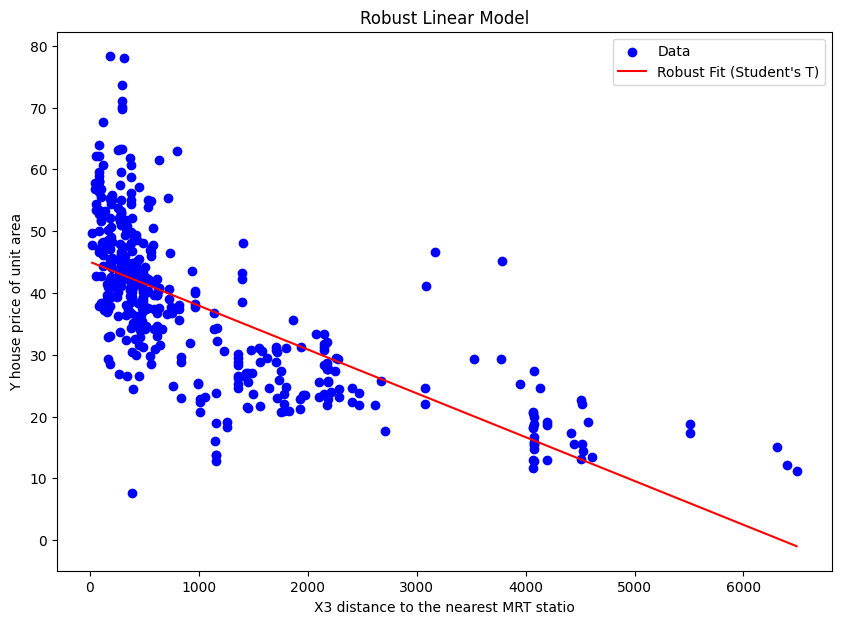

In [14]:
# Compute mean values for alpha and beta
a2_samples = robust_linear_trace.posterior['a'].values
b2_samples = robust_linear_trace.posterior['b'].values

a2_mean = a2_samples.mean()
b2_mean = b2_samples.mean()

# Generate predicted values using the mean parameter estimates
x_vals2 = np.linspace(min(real_estate['X3 distance to the nearest MRT station']), 
                     max(real_estate['X3 distance to the nearest MRT station']), 100)
y_vals_robust = a2_mean + b2_mean * x_vals2

# Plot the data with the line of best fit
plt.figure(figsize=(10, 7))
plt.scatter(real_estate['X3 distance to the nearest MRT station'], 
            real_estate['Y house price of unit area'], 
            c='blue', label='Data')
plt.plot(x_vals, y_vals_robust, c='red', label='Robust Fit (Student\'s T)')
plt.title('Robust Linear Model')
plt.xlabel('X3 distance to the nearest MRT station')
plt.ylabel('Y house price of unit area')
plt.legend()
plt.show()

interpret the resulsts here or say smth about the model

In [16]:
# Robust Quadratic Model using Student's T distribution
with pm.Model() as robust_quadratic_model:
    # Priors
    a = pm.Normal('a', mu=0, sigma=100)
    b = pm.Normal('b', mu=0, sigma=10)
    c = pm.Normal('c', mu=0, sigma=10)  # quadratic term coefficient
    nu = pm.Exponential('nu', 1/30) + 1  # degrees of freedom for Student's T
    sigma = pm.Uniform('sigma', 0, 30)
    
    # Quadratic function
    mu = a + b * real_estate['X3 distance to the nearest MRT station'] + c * real_estate['X3 distance to the nearest MRT station']**2
    
    # Robust likelihood using Student's T distribution
    unit_price = pm.StudentT('unit_price', mu=mu, nu=nu, sigma=sigma, 
                          observed=real_estate['Y house price of unit area'])
    
    # Sampling
    robust_quadratic_trace = pm.sample(tune=1000, draws=1000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [a, b, c, nu, sigma]
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


ValueError: Not enough samples to build a trace.

In [ ]:
# Compute mean values for the parameters
a3_samples = robust_quadratic_trace.posterior['a'].values
b3_samples = robust_quadratic_trace.posterior['b'].values
c3_samples = robust_quadratic_trace.posterior['c'].values

a3_mean = a3_samples.mean()
b3_mean = b3_samples.mean()
c3_mean = c3_samples.mean()

# Generate predicted values using the mean parameter estimates
x_vals3 = np.linspace(min(real_estate['X3 distance to the nearest MRT station']), 
                     max(real_estate['X3 distance to the nearest MRT station']), 100)
y_vals_robust_quadratic = a3_mean + b3_mean * x_vals3 + c3_mean * x_vals3**2

# Plot the data with the line of best fit
plt.figure(figsize=(10, 7))
plt.scatter(real_estate['X3 distance to the nearest MRT station'], 
            real_estate['tax_revenue'], 
            c='blue', label='Data')
plt.plot(x_vals, y_vals_robust_quadratic, c='red', label='Robust Quadratic Fit (Student\'s T)')
plt.title('Robust Quadratic Model')
plt.xlabel('X3 distance to the nearest MRT station')
plt.ylabel('Y house price of unit area')
plt.legend()
plt.show()

## Model 3: Outlier Detection Likelihood 

Discuss model 3 here

## Comparison of the 3 Models: PSIS leave-one-out cross-validation

Discuss what you are going to do to compare the three models

## References

references go here

#### AI Policy Statement

Your Statement Goes Here